# Integrantes:
* Juan Sebastian Arce 
* Juan Sebastian Montoya

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import random
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras import Model, Sequential
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import Input, Reshape, Dense, Dropout, \
    Activation, LeakyReLU, Conv2D, Conv2DTranspose, Embedding, \
    Concatenate, multiply, Flatten, BatchNormalization
from tensorflow.keras.initializers import glorot_normal
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [3]:
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
weight_init = glorot_normal(seed=SEED)

In [4]:
def change_image_shape(images):
    shape_tuple = images.shape
    if len(shape_tuple) == 3:
        images = images.reshape(-1, shape_tuple[-1], shape_tuple[-1], 1)
    elif shape_tuple == 4 and shape_tuple[-1] > 3:
        images = images.reshape(-1, shape_tuple[-1], shape_tuple[-1], shape_tuple[1])
    return images

In [5]:
# # Load MNIST Fashion
#from tensorflow.keras.datasets.fashion_mnist import load_data
# # Load CIFAR-10
# from tensorflow.keras.datasets.cifar10 import load_data

In [6]:
# # Load training set
#(images, labels), (_,_) = load_data()
#images = change_image_shape(images)

#labels = labels.reshape(-1)
# # # Convert from ints to floats
# # images = images.astype('float32')

In [7]:
# Create imbalanced version
#for c in range(1, 10):
#    images = np.vstack([images[labels!=c], images[labels==c][:100*c]])
#    labels = np.append(labels[labels!=c], np.ones(100*c) * c)

In [8]:
######################## Our Dataset ##########################
# # Use our datasets
#images = np.load('x_train.npy')
#labels = np.load('y_train.npy')
#images = change_image_shape(images)

train_data = np.load('/content/drive/MyDrive/deep_learning_avanzado/images_to_npy-master/dataset.npz')
images = train_data['x']
labels = train_data['y']

In [9]:
# Set channel
channel = images.shape[-1]

In [10]:
# to 64 x 64 x channel
real = np.ndarray(shape=(images.shape[0], 64, 64, channel))
for i in range(images.shape[0]):
    real[i] = cv2.resize(images[i], (64, 64)).reshape((64, 64, channel))

In [11]:
# Train test split, for autoencoder (actually, this step is redundant if we already have test set)
x_train, x_test, y_train, y_test = train_test_split(real, labels, test_size=0.3, shuffle=True, random_state=42)

In [12]:
# It is suggested to use [-1, 1] input for GAN training
x_train = (x_train.astype('float32') - 127.5) / 127.5
x_test = (x_test.astype('float32') - 127.5) / 127.5

In [13]:
# Get image size
img_size = x_train[0].shape
# Get number of classes
n_classes = len(np.unique(y_train))

In [14]:
optimizer = Adam(lr=0.0002, beta_1=0.5, beta_2=0.9)
latent_dim=128
# trainRatio === times(Train D) / times(Train G)
trainRatio = 5

In [15]:
# Build Generator/Decoder
def decoder():
    # weight initialization
    init = RandomNormal(stddev=0.02)

    noise_le = Input((latent_dim,))

    x = Dense(4*4*256)(noise_le)
    x = LeakyReLU(alpha=0.2)(x)

    ## Size: 4 x 4 x 256
    x = Reshape((4, 4, 256))(x)

    ## Size: 8 x 8 x 128
    x = Conv2DTranspose(filters=128,
                        kernel_size=(4, 4),
                        strides=(2, 2),
                        padding='same',
                        kernel_initializer=init)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    ## Size: 16 x 16 x 128
    x = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    ## Size: 32 x 32 x 64
    x = Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    ## Size: 64 x 64 x 3
    generated = Conv2DTranspose(channel, (4, 4), strides=(2, 2), padding='same', activation='tanh', kernel_initializer=init)(x)


    generator = Model(inputs=noise_le, outputs=generated)
    return generator

In [16]:
# Build Encoder
def encoder():
    # weight initialization
    init = RandomNormal(stddev=0.02)

    img = Input(img_size)

    x = Conv2D(64, kernel_size=(4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(img)
    # x = LayerNormalization()(x) # It is not suggested to use BN in Discriminator of WGAN
    x = LeakyReLU(0.2)(x)
    # x = Dropout(0.3)(x)

    x = Conv2D(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(x)
    # x = LayerNormalization()(x)
    x = LeakyReLU(0.2)(x)
    # x = Dropout(0.3)(x)

    x = Conv2D(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(x)
    # x = LayerNormalization()(x)
    x = LeakyReLU(0.2)(x)
    # x = Dropout(0.3)(x)

    x = Conv2D(256, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(x)
    # x = LayerNormalization()(x)
    x = LeakyReLU(0.2)(x)
    # x = Dropout(0.3)(x)

    # 4 x 4 x 256
    feature = Flatten()(x)

    feature = Dense(latent_dim)(feature)
    out = LeakyReLU(0.2)(feature)

    model = Model(inputs=img, outputs=out)
    return model

In [17]:
# Build Embedding model
def embedding_labeled_latent():
    # # weight initialization
    # init = RandomNormal(stddev=0.02)

    label = Input((1,), dtype='int32')
    noise = Input((latent_dim,))
    # ne = Dense(256)(noise)
    # ne = LeakyReLU(0.2)(ne)

    le = Flatten()(Embedding(n_classes, latent_dim)(label))
    # le = Dense(256)(le)
    # le = LeakyReLU(0.2)(le)

    noise_le = multiply([noise, le])
    # noise_le = Dense(latent_dim)(noise_le)

    model = Model([noise, label], noise_le)

    return model

In [18]:
# Build Autoencoder
def autoencoder_trainer(encoder, decoder, embedding):

    label = Input((1,), dtype='int32')
    img = Input(img_size)

    latent = encoder(img)
    labeled_latent = embedding([latent, label])
    rec_img = decoder(labeled_latent)
    model = Model([img, label], rec_img)

    model.compile(optimizer=optimizer, loss='mae')
    return model

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/50
7/7 [==============================] - 16s 236ms/step - loss: 0.4175 - val_loss: 0.6147
Epoch 2/50
7/7 [==============================] - 0s 71ms/step - loss: 0.2067 - val_loss: 0.5908
Epoch 3/50
7/7 [==============================] - 0s 57ms/step - loss: 0.1903 - val_loss: 0.5722
Epoch 4/50
7/7 [==============================] - 0s 57ms/step - loss: 0.1741 - val_loss: 0.5481
Epoch 5/50
7/7 [==============================] - 0s 59ms/step - loss: 0.1564 - val_loss: 0.5248
Epoch 6/50
7/7 [==============================] - 0s 57ms/step - loss: 0.1516 - val_loss: 0.5096
Epoch 7/50
7/7 [==============================] - 0s 57ms/step - loss: 0.1369 - val_loss: 0.4781
Epoch 8/50
7/7 [==============================] - 0s 57ms/step - loss: 0.1336 - val_loss: 0.4627
Epoch 9/50
7/7 [==============================] - 0s 58ms/step - loss: 0.1276 - val_loss: 0.4581
Epoch 10/50
7/7 [==============================] - 0s 57ms/step - loss: 0.1268 - val_loss: 0.4392
Epoch 11/50
7/7 [==========

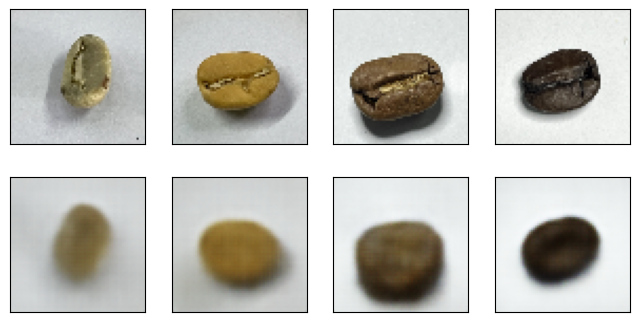

In [19]:
# Build Autoencoder
def autoencoder_trainer(encoder, decoder, embedding):

    label = Input((1,), dtype='int32')
    img = Input(img_size)

    latent = encoder(img)
    labeled_latent = embedding([latent, label])
    rec_img = decoder(labeled_latent)
    model = Model([img, label], rec_img)

    model.compile(optimizer=optimizer, loss='mae')
    return model

# Train Autoencoder
en = encoder()
de = decoder()
em = embedding_labeled_latent()
ae = autoencoder_trainer(en, de, em)

ae.fit([x_train, y_train], x_train,
       epochs=50,
       batch_size=128,
       shuffle=True,
       validation_data=([x_test, y_test], x_test))

# Show results of reconstructed images
decoded_imgs = ae.predict([x_test, y_test])
n = n_classes
plt.figure(figsize=(2*n, 4))
decoded_imgs = decoded_imgs*0.5 + 0.5
x_real = x_test*0.5 + 0.5
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    if channel == 3:
        plt.imshow(x_real[y_test==i][0].reshape(64, 64, channel))
    else:
        plt.imshow(x_real[y_test==i][0].reshape(64, 64))
        plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    if channel == 3:
        plt.imshow(decoded_imgs[y_test==i][0].reshape(64, 64, channel))
    else:
        plt.imshow(decoded_imgs[y_test==i][0].reshape(64, 64))
        plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [20]:
# Build Discriminator without inheriting the pre-trained Encoder
# Similar to cWGAN
def discriminator_cwgan():
    # weight initialization
    init = RandomNormal(stddev=0.02)

    img = Input(img_size)
    label = Input((1,), dtype='int32')


    x = Conv2D(64, kernel_size=(4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(img)
    # x = LayerNormalization()(x) # It is not suggested to use BN in Discriminator of WGAN
    x = LeakyReLU(0.2)(x)
    # x = Dropout(0.3)(x)

    x = Conv2D(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(x)
    # x = LayerNormalization()(x)
    x = LeakyReLU(0.2)(x)
    # x = Dropout(0.3)(x)

    x = Conv2D(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(x)
    # x = LayerNormalization()(x)
    x = LeakyReLU(0.2)(x)
    # x = Dropout(0.3)(x)

    x = Conv2D(256, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(x)
    # x = LayerNormalization()(x)
    x = LeakyReLU(0.2)(x)
    # x = Dropout(0.3)(x)

    x = Flatten()(x)

    le = Flatten()(Embedding(n_classes, 512)(label))
    le = Dense(4 * 4 * 256)(le)
    le = LeakyReLU(0.2)(le)
    x_y = multiply([x, le])
    x_y = Dense(512)(x_y)

    out = Dense(1)(x_y)

    model = Model(inputs=[img, label], outputs=out)

    return model

In [21]:
# Refer to the WGAN-GP Architecture. https://github.com/keras-team/keras-io/blob/master/examples/generative/wgan_gp.py
# Build our BAGAN-GP
class BAGAN_GP(Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=3,
        gp_weight=10.0,
    ):
        super(BAGAN_GP, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.train_ratio = trainRatio
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(BAGAN_GP, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, real_images, fake_images, labels):
        """ Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # get the interplated image
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator([interpolated, labels], training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calcuate the norm of the gradients
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, data):
        if isinstance(data, tuple):
            real_images = data[0]
            labels = data[1]

        # Get the batch size
        batch_size = tf.shape(real_images)[0]

        ########################### Train the Discriminator ###########################
        # For each batch, we are going to perform cwgan-like process
        for i in range(self.train_ratio):
            # Get the latent vector
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            fake_labels = tf.random.uniform((batch_size,), 0, n_classes)
            wrong_labels = tf.random.uniform((batch_size,), 0, n_classes)
            with tf.GradientTape() as tape:
                # Generate fake images from the latent vector
                fake_images = self.generator([random_latent_vectors, fake_labels], training=True)
                # Get the logits for the fake images
                fake_logits = self.discriminator([fake_images, fake_labels], training=True)
                # Get the logits for real images
                real_logits = self.discriminator([real_images, labels], training=True)
                # Get the logits for wrong label classification
                wrong_label_logits = self.discriminator([real_images, wrong_labels], training=True)

                # Calculate discriminator loss using fake and real logits
                d_cost = self.d_loss_fn(real_logits=real_logits, fake_logits=fake_logits,
                                        wrong_label_logits=wrong_label_logits
                                        )

                # Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, real_images, fake_images, labels)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * self.gp_weight

            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )

        ########################### Train the Generator ###########################
        # Get the latent vector
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        fake_labels = tf.random.uniform((batch_size,), 0, n_classes)
        with tf.GradientTape() as tape:
            # Generate fake images using the generator
            generated_images = self.generator([random_latent_vectors, fake_labels], training=True)
            # Get the discriminator logits for fake images
            gen_img_logits = self.discriminator([generated_images, fake_labels], training=True)
            # Calculate the generator loss
            g_loss = self.g_loss_fn(gen_img_logits)

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        return {"d_loss": d_loss, "g_loss": g_loss}

In [22]:
# Optimizer for both the networks
# learning_rate=0.0002, beta_1=0.5, beta_2=0.9 are recommended
generator_optimizer = Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
discriminator_optimizer = Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)

In [23]:
# We refer to the DRAGAN loss function. https://github.com/kodalinaveen3/DRAGAN
# Define the loss functions to be used for discrimiator
# We will add the gradient penalty later to this loss function
def discriminator_loss(real_logits, fake_logits, wrong_label_logits):
    real_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=real_logits, labels=tf.ones_like(real_logits)))
    fake_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logits, labels=tf.zeros_like(fake_logits)))
    wrong_label_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=wrong_label_logits, labels=tf.zeros_like(fake_logits)))

    return wrong_label_loss + fake_loss + real_loss

In [24]:
# Define the loss functions to be used for generator
def generator_loss(fake_logits):
    fake_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logits, labels=tf.ones_like(fake_logits)))
    return fake_loss

In [25]:
# build generator with pretrained decoder and embedding
def generator_label(embedding, decoder):
    # # Embedding model needs to be trained along with GAN training
    # embedding.trainable = False

    label = Input((1,), dtype='int32')
    latent = Input((latent_dim,))

    labeled_latent = embedding([latent, label])
    gen_img = decoder(labeled_latent)
    model = Model([latent, label], gen_img)

    return model

In [26]:
# Build discriminator with pre-trained Encoder
def build_discriminator(encoder):

    label = Input((1,), dtype='int32')
    img = Input(img_size)

    inter_output_model = Model(inputs=encoder.input, outputs=encoder.layers[-3].output)
    x = inter_output_model(img)

    le = Flatten()(Embedding(n_classes, 512)(label))
    le = Dense(4 * 4 * 256)(le)
    le = LeakyReLU(0.2)(le)
    x_y = multiply([x, le])
    x_y = Dense(512)(x_y)

    out = Dense(1)(x_y)

    model = Model(inputs=[img, label], outputs=out)

    return model

In [27]:
# d_model = build_discriminator(en)  # initialized with Encoder
d_model = discriminator_cwgan()  # without initialization
g_model = generator_label(em, de)  # initialized with Decoder and Embedding

bagan_gp = BAGAN_GP(
    discriminator=d_model,
    generator=g_model,
    latent_dim=latent_dim,
    discriminator_extra_steps=3,
)

# Compile the model
bagan_gp.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)

In [28]:
# Plot/save generated images through training
def plt_img(generator, epoch):
    np.random.seed(42)
    latent_gen = np.random.normal(size=(n_classes, latent_dim))

    x_real = x_test * 0.5 + 0.5
    n = n_classes

    plt.figure(figsize=(2*n, 2*(n+1)))
    for i in range(n):
        # display original
        ax = plt.subplot(n+1, n, i + 1)
        if channel == 3:
            plt.imshow(x_real[y_test==i][4].reshape(64, 64, channel))
        else:
            plt.imshow(x_real[y_test == i][4].reshape(64, 64))
            plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        for c in range(n):
            decoded_imgs = generator.predict([latent_gen, np.ones(n)*c])
            decoded_imgs = decoded_imgs * 0.5 + 0.5
            # display generation
            ax = plt.subplot(n+1, n, (i+1)*n + 1 + c)
            if channel == 3:
                plt.imshow(decoded_imgs[i].reshape(64, 64, channel))
            else:
                plt.imshow(decoded_imgs[i].reshape(64, 64))
                plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.savefig('bagan_gp_results/generated_plot_%d.png' % epoch)
    plt.show()
    return

In [29]:
# make directory to store results
os.system('mkdir -p bagan_gp_results')

# Record the loss
d_loss_history = []
g_loss_history = []


In [30]:
LEARNING_STEPS = 150
for learning_step in range(LEARNING_STEPS):
    print('LEARNING STEP # ', learning_step + 1, '-' * 50)
    bagan_gp.fit(x_train, y_train, batch_size=128, epochs=2)
    d_loss_history += bagan_gp.history.history['d_loss']
    g_loss_history += bagan_gp.history.history['g_loss']
    if (learning_step+1)%1 == 0:
        plt_img(bagan_gp.generator, learning_step)

Output hidden; open in https://colab.research.google.com to view.

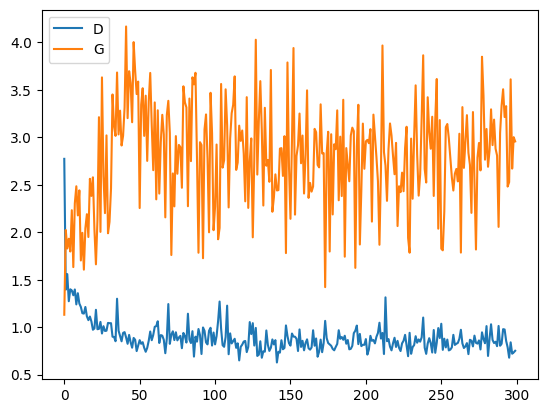

In [31]:
# plot loss of G and D
plt.plot(d_loss_history, label='D')
plt.plot(g_loss_history, label='G')
plt.legend()
plt.show()

In [32]:
# save gif
import imageio
ims = []
for i in range(LEARNING_STEPS):
    fname = 'generated_plot_%d.png' % i
    dir = 'bagan_gp_results/'
    if fname in os.listdir(dir):
        print('loading png...', i)
        im = imageio.imread(dir + fname, 'png')
        ims.append(im)
print('saving as gif...')
imageio.mimsave(dir + 'training_demo.gif', ims, fps=3)

loading png... 0
loading png... 1
loading png... 2
loading png... 3
loading png... 4
loading png... 5
loading png... 6
loading png... 7


<ipython-input-32-02bb7630f078>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread(dir + fname, 'png')


loading png... 8
loading png... 9
loading png... 10
loading png... 11
loading png... 12
loading png... 13
loading png... 14
loading png... 15
loading png... 16
loading png... 17
loading png... 18
loading png... 19
loading png... 20
loading png... 21
loading png... 22
loading png... 23
loading png... 24
loading png... 25
loading png... 26
loading png... 27
loading png... 28
loading png... 29
loading png... 30
loading png... 31
loading png... 32
loading png... 33
loading png... 34
loading png... 35
loading png... 36
loading png... 37
loading png... 38
loading png... 39
loading png... 40
loading png... 41
loading png... 42
loading png... 43
loading png... 44
loading png... 45
loading png... 46
loading png... 47
loading png... 48
loading png... 49
loading png... 50
loading png... 51
loading png... 52
loading png... 53
loading png... 54
loading png... 55
loading png... 56
loading png... 57
loading png... 58
loading png... 59
loading png... 60
loading png... 61
loading png... 62
loading png.

## INCEPTION SCORE

In [33]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [34]:
# calculate inception score 
from math import floor
from numpy import ones
from numpy import expand_dims
from numpy import log
from numpy import mean
from numpy import std
from numpy import exp
from numpy.random import shuffle
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from skimage.transform import resize
from numpy import asarray

In [35]:
# scale an array of images to a new size
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return asarray(images_list)

In [36]:
# assumes images have any shape and pixels in [0,255]
def calculate_inception_score(images, n_split=10, eps=1E-16):
	# load inception v3 model
	model = InceptionV3()
	# enumerate splits of images/predictions
	scores = list()
	n_part = floor(images.shape[0] / n_split)
	for i in range(n_split):
		# retrieve images
		ix_start, ix_end = i * n_part, (i+1) * n_part
		subset = images[ix_start:ix_end]
		# convert from uint8 to float32
		subset = subset.astype('float32')
		# scale images to the required size
		subset = scale_images(subset, (299,299,3))
		# pre-process images, scale to [-1,1]
		subset = preprocess_input(subset)
		# predict p(y|x)
		p_yx = model.predict(subset)
		# calculate p(y)
		p_y = expand_dims(p_yx.mean(axis=0), 0)
		# calculate KL divergence using log probabilities
		kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
		# sum over classes
		sum_kl_d = kl_d.sum(axis=1)
		# average over images
		avg_kl_d = mean(sum_kl_d)
		# undo the log
		is_score = exp(avg_kl_d)
		# store
		scores.append(is_score)
	# average across images
	is_avg, is_std = mean(scores), std(scores)
	return is_avg, is_std

In [37]:
# Get the list of file names in the image folder
image_folder = '/content/drive/MyDrive/deep_learning_avanzado/images_to_npy-master/image_dir'
file_names = sorted(os.listdir(image_folder))

# Load the images into an array
images = []
for file_name in file_names:
    file_path = os.path.join(image_folder, file_name)
    image = plt.imread(file_path)
    images.append(image)

# Convert the list of images to a numpy array
images = np.array(images)

# Shuffle the images
shuffle(images)

print('Loaded', images.shape[0], 'images')

# Calculate the Inception score
is_avg, is_std = calculate_inception_score(images[:1000])

print('Inception score average:', is_avg)
print('Inception score standard deviation:', is_std)

Loaded 1200 images
4/4 [==============================] - 0s 102ms/step
Inception score average: 1.0164211
Inception score standard deviation: 0.0019186445
